In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir
import ast
from pprint import pprint
from bm3dornl.bm3d import bm3d_ring_artifact_removal_ms
from bm3dornl.bm3d import bm3d_ring_artifact_removal
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
ncore

256

# Workflow starts here!

In [4]:
###################### need to change start
instrument = "/HFIR/CG1D"
# instrument = "/SNS/VENUS"
ipts = "23788"
###################### need to change end

In [5]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
hdf5_loc = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(hdf5_loc)

['2023_06_12_copper_ore_redo.h5',
 '2021_09_03_gold_ore_wim_456proj_gridrec.h5',
 '2022_10_22_wood.h5']

In [6]:
###################### need to change start
sample_name = "2021_09_03_gold_ore_wim_456proj_gridrec"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [7]:
losa.get_hdf_tree(hdf5)
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
pprint(history_dict)

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (456,)
    │   ├── ang_rad (456,)
    │   ├── fname (456,)
    │   ├── proj000_idx (1,)
    │   ├── proj180_idx (1,)
    │   └── proj360_idx (1,)
    ├── proj
    │   │
    │   ├── proj_mlog_pre_ring (456, 1200, 699)
    │   ├── proj_mlog_pre_tilt (456, 1580, 700)
    │   ├── proj_mlog_to_recon (456, 1200, 699)
    │   └── proj_norm_pre_tilt (456, 1580, 700)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── fluc_corr_roi_min (379, 170)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (1580, 700)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (1200, 570, 370)
    └── sino
        │
        ├── sino_mlog_pre_ring (1200, 456, 699)
        ├── sino_mlog_pre_tilt (1580, 456, 700)
        └── sino_mlog_to_recon (1200, 456, 699)
{'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'bottom': -1,
                       

In [8]:
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
# proj_mlog = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
sino_mlog = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_pre_ring')
sino_mlog_rmv = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
rot_center = history_dict['rot_center']
# recon_hdf5 = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')
gamma_diff = 20
# sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)
if 'recon_crop_roi' in history_dict.keys():
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None
history_dict

{'crop': True,
 'crop_roi_dict': {'left': 250, 'right': 950, 'top': 120, 'bottom': 1700},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 1,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 0,
  'right': 170,
  'top': 1200,
  'bottom': -1},
 'minus_log': True,
 'tilt_corr_used': 'neutompy',
 'define_roi': True,
 'define_roi_dict': {'left': 0, 'right': -1, 'top': 0, 'bottom': 1200},
 'rot_center_180': 361.75,
 'rot_center_360': 361.98568058013916,
 'rot_center': 361.98568058013916,
 'tilt_corr_theta': -0.1403719241553615,
 'tilt_corr_shift': 0,
 'ring_removal': 'bm3dgpu',
 'pixel_size_um': 42,
 'recon_unit': 'cm-1',
 'start_ang_idx': 0,
 'end_ang_idx': 455,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'left': 180, 'right': 550, 'top': 50, 'bottom': 620}}

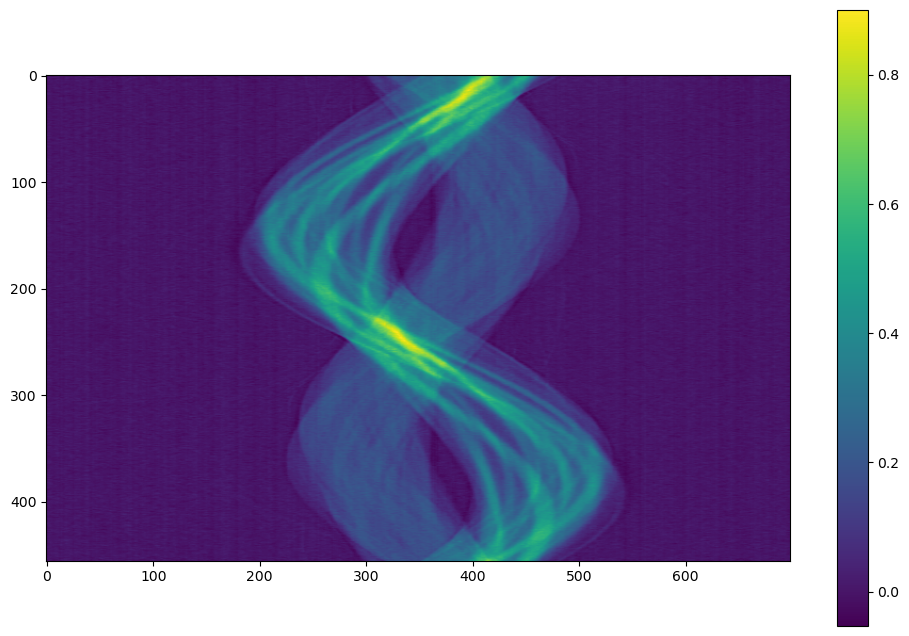

In [9]:
###################### need to change start
idx = 500
###################### need to change end
plt.imshow(sino_mlog[idx])
plt.colorbar()
plt.show()

In [39]:
slice_num = 500
test_method = 'ornl'
#######################
t0 = timeit.default_timer()
if test_method == 'ornl_fast':
    sino_mlog_rmv_test = rocku.estimate_noise_free_sinogram(sino_mlog[slice_num])
elif test_method == 'ornl':
    sino_mlog_rmv_test = bm3d_ring_artifact_removal(sino_mlog[slice_num])
elif test_method == 'ornl_ms':
    sino_mlog_rmv_test = bm3d_ring_artifact_removal_ms(sino_mlog[slice_num])
t1 = timeit.default_timer()
print("Time of tested filtering: {} s".format(round(t1-t0, 3)))
####################### 
rec_img = rec.gridrec_reconstruction(sino_mlog[slice_num], rot_center, angles=ang_rad, 
                                      apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                      ncore=ncore
                                     )
if recon_crop:
    rec_img = rocku.crop(rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
#######################
rec_img_bm3d = rec.gridrec_reconstruction(sino_mlog_rmv[slice_num], rot_center, angles=ang_rad, 
                                      apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                      ncore=ncore
                                     )
if recon_crop:
    rec_img_bm3d = rocku.crop(rec_img_bm3d, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
#######################
rec_img_test = rec.gridrec_reconstruction(sino_mlog_rmv_test, rot_center, angles=ang_rad, 
                                      apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                      ncore=ncore
                                     )
if recon_crop:
    rec_img_test = rocku.crop(rec_img_test, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

Time of tested filtering: 5.847 s


Text(0.5, 1.0, 'Recon slice, after ring removal (ornl)')

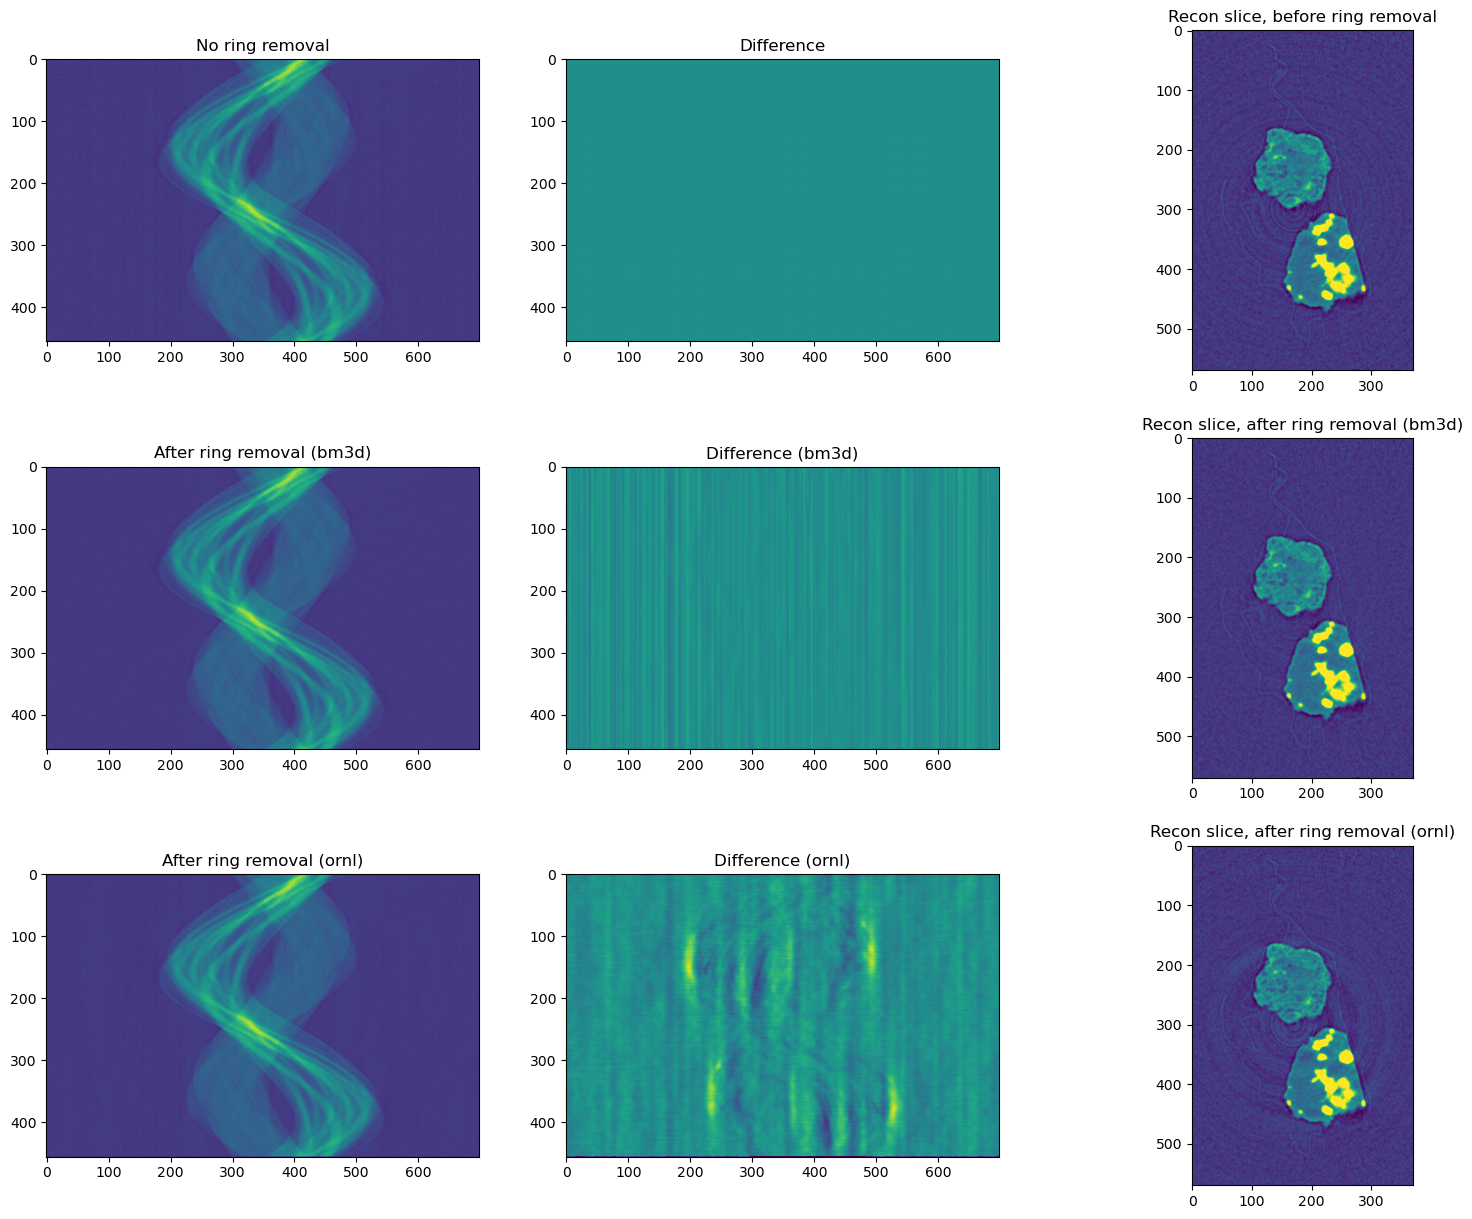

In [40]:
#######################
f, ax = plt.subplots(3, 3, figsize=(19, 15))
rr_roi = False
if rr_roi:
    slice_num_before = slice_num + rr_roi_top
else:
    slice_num_before = slice_num
ax[0][0].imshow(sino_mlog[slice_num_before], vmin=-0.2, vmax=1)
ax[0][0].set_title('No ring removal')
ax[0][1].imshow(sino_mlog[slice_num_before] - sino_mlog[slice_num_before], vmin=-0.05, vmax=0.05)
ax[0][1].set_title('Difference')
ax[0][2].imshow(rec_img, vmin=-0.001, vmax=0.005)
ax[0][2].set_title('Recon slice, before ring removal')

ax[1][0].imshow(sino_mlog_rmv[slice_num_before], vmin=-0.2, vmax=1)
ax[1][0].set_title('After ring removal (bm3d)')
ax[1][1].imshow(sino_mlog_rmv[slice_num_before] - sino_mlog[slice_num_before], vmin=-0.05, vmax=0.05)#sino_mlog_rmv_test - sino_mlog[slice_num_before])
ax[1][1].set_title('Difference (bm3d)')
ax[1][2].imshow(rec_img_bm3d, vmin=-0.001, vmax=0.005)
ax[1][2].set_title('Recon slice, after ring removal (bm3d)')

ax[2][0].imshow(sino_mlog_rmv_test, vmin=-0.2, vmax=1)
ax[2][0].set_title('After ring removal ({})'.format(test_method))
ax[2][1].imshow(sino_mlog_rmv_test - sino_mlog[slice_num_before], vmin=-0.05, vmax=0.05)
ax[2][1].set_title('Difference ({})'.format(test_method))
ax[2][2].imshow(rec_img_test, vmin=-0.001, vmax=0.005)
ax[2][2].set_title('Recon slice, after ring removal ({})'.format(test_method))